# UMAP outlier analysis with coSMicQC

This notebook analyzes [JUMP](https://jump-cellpainting.broadinstitute.org/) data (`cpg0000-jump-pilot`) by leveraging [UMAP](https://arxiv.org/abs/1802.03426) and [coSMicQC](https://github.com/WayScience/coSMicQC).

## Outline

We focus on a single file from the JUMP dataset: [`BR00117006.sqlite`](https://open.quiltdata.com/b/cellpainting-gallery/tree/cpg0000-jump-pilot/source_4/workspace/backend/2020_11_04_CPJUMP1/BR00117006/BR00117006.sqlite).
This file is downloaded and prepared by [CytoTable](https://github.com/cytomining/CytoTable) to form a single-cell [Parquet](https://parquet.apache.org/) file which includes all compartment feature data at the single-cell level (performed in step 0, outside of this notebook).
We use coSMicQC to find and remove erroneous outlier data in order to prepare for UMAP analysis.
Afterwards, we use UMAP to demonstrate patterns within the data.

In [1]:
import logging
import pathlib
from typing import List, Optional

import cosmicqc
import duckdb
import holoviews
import hvplot.pandas
import numpy as np
import pandas as pd
import plotly.express as px
import pycytominer
import umap
from IPython.display import HTML, Image
from pyarrow import parquet

# set bokeh for visualizations with hvplot
hvplot.extension("bokeh")

# avoid displaying plot export warnings
logging.getLogger("bokeh.io.export").setLevel(logging.ERROR)

# set the plate name for use throughout the notebook
example_plate = "BR00117006"

## Define utility functions for use within this notebook

In [2]:
def generate_umap_embeddings(
    df_input: pd.DataFrame,
    cols_metadata_to_exclude: List[str],
    umap_n_components: int = 2,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    Generates UMAP (Uniform Manifold Approximation and Projection)
    embeddings for a given input dataframe,
    excluding specified metadata columns.

    Args:
        df_input (pd.DataFrame]):
            A dataframe which is expected to contain
            numeric columns to be used for UMAP fitting.
        cols_metadata_to_exclude (List[str]):
            A list of column names representing
            metadata columns that should be excluded
            from the UMAP transformation.
        umap_n_components: (int):
            Number of components to use for UMAP.
            Default = 2.
        random_state (int):
            Number to use for random state and
            optional determinism.
            Default = None (random each time)
            Note: values besides None will turn
            off parallelism for umap-learn, likely
            meaning increased processing time.

    Returns:
        np.ndarray:
            A dataframe containing the UMAP embeddings
            with 2 components for each row in the input.
    """

    # Make sure to reinitialize UMAP instance per plate
    umap_fit = umap.UMAP(
        n_components=umap_n_components,
        random_state=random_state,
        # set the default value if we didn't set a random_state
        # otherwise set to 1 (umap-learn will override anyways).
        # this is set to avoid warnings from umap-learn during
        # processing.
        n_jobs=-1 if random_state is None else 1,
    )

    # Fit UMAP and convert to pandas DataFrame
    embeddings = umap_fit.fit_transform(
        X=df_input[
            [
                col
                for col in df_input.columns.tolist()
                if col not in cols_metadata_to_exclude and "cqc." not in col
            ]
            # select only numeric types from the dataframe
        ].select_dtypes(include=[np.number])
    )

    return embeddings

In [3]:
def plot_hvplot_scatter(
    embeddings: np.ndarray,
    title: str,
    filename: str,
    color_dataframe: Optional[pd.DataFrame] = None,
    color_column: Optional[str] = None,
    bgcolor: str = "black",
    cmap: str = "plasma",
    clabel: Optional[str] = None,
) -> holoviews.core.spaces.DynamicMap:
    """
    Creates an outlier-focused scatter hvplot for viewing
    UMAP embedding data with cosmicqc outliers coloration.

    Args:
        embeddings (np.ndarray]):
            A numpy ndarray which includes
            embedding data to display.
        title (str):
            Title for the UMAP scatter plot.
        filename (str):
            Filename which indicates where to export the
            plot.
        color_dataframe (pd.DataFrame):
            A dataframe which includes data used for
            color mapping within the plot. For example,
            coSMicQC .is_outlier columns.
        color_column (str):
            Column name from color_dataframe to use
            for coloring the scatter plot.
        bgcolor (str):
            Sets the background color of the plot.
        cmap (str):
            Sets the colormap used for the plot.
            See here for more:
            https://holoviews.org/user_guide/Colormaps.html
        clabel (str):
            Sets a label on the color map key displayed
            horizontally. Defaults to None (no label).

    Returns:
        holoviews.core.spaces.DynamicMap:
            A dynamic holoviews scatter plot which may be
            displayed in a Jupyter notebook.
    """

    # build a scatter plot through hvplot
    plot = pd.DataFrame(embeddings).hvplot.scatter(
        title=title,
        x="0",
        y="1",
        alpha=0.1,
        rasterize=True,
        c=(
            color_dataframe[color_column].astype(int).values
            if color_dataframe is not None
            else None
        ),
        cnorm="linear",
        cmap=cmap,
        bgcolor=bgcolor,
        height=700,
        width=800,
        clabel=clabel,
    )

    # export the plot
    hvplot.save(obj=plot, filename=filename, center=False)

    return plot

In [4]:
# form a path to the parquet file with single-cell profiles
merged_single_cells = (
    f"../0.download_data/data/plates/{example_plate}/{example_plate}.parquet"
)

# read only the metadata from parquet file
parquet.ParquetFile(merged_single_cells).metadata

  created_by: parquet-cpp-arrow version 17.0.0
  num_columns: 7390
  num_rows: 491838
  num_row_groups: 53
  format_version: 2.6
  serialized_size: 58923224

## Process merged single-cell data using coSMicQC

In [5]:
# show the first few columns for metadata column names
schema_names = parquet.read_schema(merged_single_cells).names
schema_names[:12]

['Metadata_ImageNumber',
 'Image_Metadata_AbsPositionZ',
 'Image_Metadata_AbsTime',
 'Image_Metadata_BinningX',
 'Image_Metadata_BinningY',
 'Image_Metadata_ChannelID',
 'Image_Metadata_ChannelName',
 'Image_Metadata_Col',
 'Image_Metadata_ExposureTime',
 'Image_Metadata_FieldID',
 'Image_Metadata_ImageResolutionX',
 'Image_Metadata_ImageResolutionY']

In [6]:
# set a list of metadata columns for use throughout
metadata_cols = [
    "Metadata_ImageNumber",
    "Image_Metadata_Row",
    "Image_Metadata_Site",
    "Metadata_ObjectNumber",
    "Metadata_Plate",
    "Metadata_Well",
    "Image_TableNumber",
    "Image_FileName_CellOutlines",
    "Image_FileName_NucleiOutlines",
    "Image_FileName_OrigAGP",
    "Image_FileName_OrigDNA",
    "Image_FileName_OrigRNA",
    "Cytoplasm_AreaShape_BoundingBoxMaximum_X",
    "Cytoplasm_AreaShape_BoundingBoxMaximum_Y",
    "Cytoplasm_AreaShape_BoundingBoxMinimum_X",
    "Cytoplasm_AreaShape_BoundingBoxMinimum_Y",
]

# read only metadata columns with feature columns used for outlier detection
df_merged_single_cells = pd.read_parquet(
    path=merged_single_cells,
    columns=[
        *metadata_cols,
        "Nuclei_AreaShape_Area",
        "Nuclei_AreaShape_FormFactor",
        "Nuclei_AreaShape_Eccentricity",
    ],
)
df_merged_single_cells.head()

,Metadata_ImageNumber,Image_Metadata_Row,Image_Metadata_Site,Metadata_ObjectNumber,Metadata_Plate,Metadata_Well,Image_TableNumber,Image_FileName_CellOutlines,Image_FileName_NucleiOutlines,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigRNA,Cytoplasm_AreaShape_BoundingBoxMaximum_X,Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Cytoplasm_AreaShape_BoundingBoxMinimum_X,Cytoplasm_AreaShape_BoundingBoxMinimum_Y,Nuclei_AreaShape_Area,Nuclei_AreaShape_FormFactor,Nuclei_AreaShape_Eccentricity
0,1,1,1,1,BR00117006,A01,100953712601233197982859519342258171194,A01_s1--cell_outlines.png,A01_s1--nuclei_outlines.png,r01c01f01p01-ch2sk1fk1fl1.tiff,r01c01f01p01-ch5sk1fk1fl1.tiff,r01c01f01p01-ch3sk1fk1fl1.tiff,259,72,175,0,637,0.920464,0.412099
1,1,1,1,2,BR00117006,A01,100953712601233197982859519342258171194,A01_s1--cell_outlines.png,A01_s1--nuclei_outlines.png,r01c01f01p01-ch2sk1fk1fl1.tiff,r01c01f01p01-ch5sk1fk1fl1.tiff,r01c01f01p01-ch3sk1fk1fl1.tiff,936,67,852,0,583,0.919634,0.564031
2,1,1,1,3,BR00117006,A01,100953712601233197982859519342258171194,A01_s1--cell_outlines.png,A01_s1--nuclei_outlines.png,r01c01f01p01-ch2sk1fk1fl1.tiff,r01c01f01p01-ch5sk1fk1fl1.tiff,r01c01f01p01-ch3sk1fk1fl1.tiff,721,73,624,0,656,0.877731,0.757343
3,2,1,2,1,BR00117006,A01,10948179779460722453965434149548305036,A01_s2--cell_outlines.png,A01_s2--nuclei_outlines.png,r01c01f02p01-ch2sk1fk1fl1.tiff,r01c01f02p01-ch5sk1fk1fl1.tiff,r01c01f02p01-ch3sk1fk1fl1.tiff,82,45,0,0,637,0.939079,0.614207
4,2,1,2,2,BR00117006,A01,10948179779460722453965434149548305036,A01_s2--cell_outlines.png,A01_s2--nuclei_outlines.png,r01c01f02p01-ch2sk1fk1fl1.tiff,r01c01f02p01-ch5sk1fk1fl1.tiff,r01c01f02p01-ch3sk1fk1fl1.tiff,199,46,121,0,586,0.941767,0.579510


In [7]:
# convert dataframe into a cytodataframe
df_merged_single_cells = cosmicqc.CytoDataFrame(
    data=df_merged_single_cells,
    data_context_dir="../0.download_data/data/images/orig",
    data_mask_context_dir="../0.download_data/data/images/outlines",
)
df_merged_single_cells

Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {cand

,Metadata_ImageNumber,Image_Metadata_Row,Image_Metadata_Site,Metadata_ObjectNumber,Metadata_Plate,Metadata_Well,Image_TableNumber,Image_FileName_CellOutlines,Image_FileName_NucleiOutlines,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigRNA,Cytoplasm_AreaShape_BoundingBoxMaximum_X,Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Cytoplasm_AreaShape_BoundingBoxMinimum_X,Cytoplasm_AreaShape_BoundingBoxMinimum_Y,Nuclei_AreaShape_Area,Nuclei_AreaShape_FormFactor,Nuclei_AreaShape_Eccentricity
0,1,1,1,1,BR00117006,A01,100953712601233197982859519342258171194,A01_s1--cell_outlines.png,A01_s1--nuclei_outlines.png,r01c01f01p01-ch2sk1fk1fl1.tiff,r01c01f01p01-ch5sk1fk1fl1.tiff,r01c01f01p01-ch3sk1fk1fl1.tiff,259,72,175,0,637,0.920464,0.412099
1,1,1,1,2,BR00117006,A01,100953712601233197982859519342258171194,A01_s1--cell_outlines.png,A01_s1--nuclei_outlines.png,r01c01f01p01-ch2sk1fk1fl1.tiff,r01c01f01p01-ch5sk1fk1fl1.tiff,r01c01f01p01-ch3sk1fk1fl1.tiff,936,67,852,0,583,0.919634,0.564031
2,1,1,1,3,BR00117006,A01,100953712601233197982859519342258171194,A01_s1--cell_outlines.png,A01_s1--nuclei_outlines.png,r01c01f01p01-ch2sk1fk1fl1.tiff,r01c01f01p01-ch5sk1fk1fl1.tiff,r01c01f01p01-ch3sk1fk1fl1.tiff,721,73,624,0,656,0.877731,0.757343
3,2,1,2,1,BR00117006,A01,10948179779460722453965434149548305036,A01_s2--cell_outlines.png,A01_s2--nuclei_outlines.png,r01c01f02p01-ch2sk1fk1fl1.tiff,r01c01f02p01-ch5sk1fk1fl1.tiff,r01c01f02p01-ch3sk1fk1fl1.tiff,82,45,0,0,637,0.939079,0.614207
4,2,1,2,2,BR00117006,A01,10948179779460722453965434149548305036,A01_s2--cell_outlines.png,A01_s2--nuclei_outlines.png,r01c01f02p01-ch2sk1fk1fl1.tiff,r01c01f02p01-ch5sk1fk1fl1.tiff,r01c01f02p01-ch3sk1fk1fl1.tiff,199,46,121,0,586,0.941767,0.579510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491833,290,2,2,311,BR00117006,B09,229738698368600480636971006296591261947,B09_s2--cell_outlines.png,B09_s2--nuclei_outlines.png,r02c09f02p01-ch2sk1fk1fl1.tiff,r02c09f02p01-ch5sk1fk1fl1.tiff,r02c09f02p01-ch3sk1fk1fl1.tiff,1080,1064,1009,1005,645,0.774102,0.841505
491834,290,2,2,313,BR00117006,B09,229738698368600480636971006296591261947,B09_s2--cell_outlines.png,B09_s2--nuclei_outlines.png,r02c09f02p01-ch2sk1fk1fl1.tiff,r02c09f02p01-ch5sk1fk1fl1.tiff,r02c09f02p01-ch3sk1fk1fl1.tiff,864,1080,731,1007,950,0.834033,0.817577
491835,290,2,2,304,BR00117006,B09,229738698368600480636971006296591261947,B09_s2--cell_outlines.png,B09_s2--nuclei_outlines.png,r02c09f02p01-ch2sk1fk1fl1.tiff,r02c09f02p01-ch5sk1fk1fl1.tiff,r02c09f02p01-ch3sk1fk1fl1.tiff,594,1077,490,966,772,0.881413,0.726392
491836,290,2,2,316,BR00117006,B09,229738698368600480636971006296591261947,B09_s2--cell_outlines.png,B09_s2--nuclei_outlines.png,r02c09f02p01-ch2sk1fk1fl1.tiff,r02c09f02p01-ch5sk1fk1fl1.tiff,r02c09f02p01-ch3sk1fk1fl1.tiff,922,1080,856,1036,870,0.907817,0.649587


In [8]:
# label outliers within the dataset
print("Large nuclei outliers:")
df_labeled_outliers = cosmicqc.analyze.find_outliers(
    df=df_merged_single_cells,
    metadata_columns=metadata_cols,
    feature_thresholds="large_nuclei",
)

Large nuclei outliers:
Number of outliers: 2699 (0.55%)
Outliers Range:
Nuclei_AreaShape_Area Min: 1026
Nuclei_AreaShape_Area Max: 4319
Nuclei_AreaShape_FormFactor Min: 0.3642334535149482
Nuclei_AreaShape_FormFactor Max: 0.7792743532535591


In [9]:
# label outliers within the dataset
print("Elongated nuclei outliers:")
df_labeled_outliers = cosmicqc.analyze.find_outliers(
    df=df_merged_single_cells,
    metadata_columns=metadata_cols,
    feature_thresholds="elongated_nuclei",
)

Elongated nuclei outliers:
Number of outliers: 560 (0.11%)
Outliers Range:
Nuclei_AreaShape_Eccentricity Min: 0.9010267846069533
Nuclei_AreaShape_Eccentricity Max: 0.9966410042879617


In [10]:
# label outliers within the dataset
print("Small and low formfactor nuclei outliers:")
df_labeled_outliers = cosmicqc.analyze.find_outliers(
    df=df_merged_single_cells,
    metadata_columns=metadata_cols,
    feature_thresholds="small_and_low_formfactor_nuclei",
)

Small and low formfactor nuclei outliers:
Number of outliers: 12325 (2.51%)
Outliers Range:
Nuclei_AreaShape_Area Min: 79
Nuclei_AreaShape_Area Max: 483
Nuclei_AreaShape_FormFactor Min: 0.23113739750863993
Nuclei_AreaShape_FormFactor Max: 0.8324542109843635


In [11]:
# label outliers within the dataset
df_labeled_outliers = cosmicqc.analyze.label_outliers(
    df=df_merged_single_cells,
    include_threshold_scores=True,
)
# show added columns
df_labeled_outliers[
    [col for col in df_labeled_outliers.columns.tolist() if "cqc." in col]
].head()

,cqc.small_and_low_formfactor_nuclei.Z_Score.Nuclei_AreaShape_Area,cqc.small_and_low_formfactor_nuclei.Z_Score.Nuclei_AreaShape_FormFactor,cqc.small_and_low_formfactor_nuclei.is_outlier,cqc.elongated_nuclei.Z_Score.Nuclei_AreaShape_Eccentricity,cqc.elongated_nuclei.is_outlier,cqc.large_nuclei.Z_Score.Nuclei_AreaShape_Area,cqc.large_nuclei.Z_Score.Nuclei_AreaShape_FormFactor,cqc.large_nuclei.is_outlier
0,-0.149178,0.654414,False,-1.919829,False,-0.149178,0.654414,False
1,-0.448256,0.638814,False,-0.701700,False,-0.448256,0.638814,False
2,-0.043947,-0.148995,False,0.848206,False,-0.043947,-0.148995,False
3,-0.149178,1.004402,False,-0.299408,False,-0.149178,1.004402,False
4,-0.431641,1.054939,False,-0.577595,False,-0.431641,1.054939,False


In [12]:
# show small and low formfactor nuclei outliers
df_labeled_outliers[
    [
        "cqc.small_and_low_formfactor_nuclei.is_outlier",
        "Image_FileName_OrigAGP",
        "Image_FileName_OrigDNA",
        "Image_FileName_OrigRNA",
    ]
]

Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {candidate_path}
Unable to process image from {cand

,cqc.small_and_low_formfactor_nuclei.is_outlier,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigRNA
0,False,r01c01f01p01-ch2sk1fk1fl1.tiff,r01c01f01p01-ch5sk1fk1fl1.tiff,r01c01f01p01-ch3sk1fk1fl1.tiff
1,False,r01c01f01p01-ch2sk1fk1fl1.tiff,r01c01f01p01-ch5sk1fk1fl1.tiff,r01c01f01p01-ch3sk1fk1fl1.tiff
2,False,r01c01f01p01-ch2sk1fk1fl1.tiff,r01c01f01p01-ch5sk1fk1fl1.tiff,r01c01f01p01-ch3sk1fk1fl1.tiff
3,False,r01c01f02p01-ch2sk1fk1fl1.tiff,r01c01f02p01-ch5sk1fk1fl1.tiff,r01c01f02p01-ch3sk1fk1fl1.tiff
4,False,r01c01f02p01-ch2sk1fk1fl1.tiff,r01c01f02p01-ch5sk1fk1fl1.tiff,r01c01f02p01-ch3sk1fk1fl1.tiff
...,...,...,...,...
491833,False,r02c09f02p01-ch2sk1fk1fl1.tiff,r02c09f02p01-ch5sk1fk1fl1.tiff,r02c09f02p01-ch3sk1fk1fl1.tiff
491834,False,r02c09f02p01-ch2sk1fk1fl1.tiff,r02c09f02p01-ch5sk1fk1fl1.tiff,r02c09f02p01-ch3sk1fk1fl1.tiff
491835,False,r02c09f02p01-ch2sk1fk1fl1.tiff,r02c09f02p01-ch5sk1fk1fl1.tiff,r02c09f02p01-ch3sk1fk1fl1.tiff
491836,False,r02c09f02p01-ch2sk1fk1fl1.tiff,r02c09f02p01-ch5sk1fk1fl1.tiff,r02c09f02p01-ch3sk1fk1fl1.tiff


In [13]:
# create a column which indicates whether an erroneous outlier was detected
# from all cosmicqc outlier threshold sets. For ex. True for is_outlier in
# one threshold set out of three would show True for this column. False for
# is_outlier in all threshold sets would show False for this column.
df_labeled_outliers["analysis.included_at_least_one_outlier"] = df_labeled_outliers[
    [col for col in df_labeled_outliers.columns.tolist() if ".is_outlier" in col]
].any(axis=1)

# show value counts for all outliers
outliers_counts = df_labeled_outliers[
    "analysis.included_at_least_one_outlier"
].value_counts()
outliers_counts

analysis.included_at_least_one_outlier
False    476425
True      15413
Name: count, dtype: int64

In [14]:
# show the percentage of total dataset
print(
    (outliers_counts.iloc[1] / outliers_counts.iloc[0]) * 100,
    "%",
    "of",
    outliers_counts.iloc[0],
    "include erroneous outliers of some kind.",
)

3.2351366951776246 % of 476425 include erroneous outliers of some kind.


## Prepare data for analysis with pycytominer

In [15]:
parquet_sampled_with_outliers = f"./{example_plate}_sampled_with_outliers.parquet"

# check if we already have normalized data
if not pathlib.Path(parquet_sampled_with_outliers).is_file():
    # set a fraction for sampling to limit the amount
    # of data processed based on system memory constraints.
    # note: data was processed on system with 16 CPU, 64 GB ram
    sample_fraction = 0.08

    # select metadata columns plus those which don't exist in
    # df_features (cosmicqc or analysis-specific columns)
    df_labeled_outliers_unique_cols = df_labeled_outliers[
        [
            *metadata_cols,
            *[
                col
                for col in df_labeled_outliers.columns
                if col not in df_features.columns
            ],
        ]
    ]

    # Connect to DuckDB and read the parquet file directly
    with duckdb.connect() as ddb:

        # execute a query to extract sample of data from the file without reading it in full
        df_features_with_cqc_outlier_data = ddb.execute(
            f"""
            WITH sampled_data AS (
                SELECT *,
                       ROW_NUMBER() OVER (PARTITION BY Metadata_Well ORDER BY RANDOM()) AS rn,
                       COUNT(*) OVER (PARTITION BY Metadata_Well) AS group_count
                FROM read_parquet('{merged_single_cells}')
            )
            SELECT * FROM sampled_data
            INNER JOIN df_labeled_outliers_unique_cols AS joined_data ON
                joined_data.Metadata_ImageNumber = sampled_data.Metadata_ImageNumber 
                AND joined_data.Image_Metadata_Row = sampled_data.Image_Metadata_Row
                AND joined_data.Image_Metadata_Site = sampled_data.Image_Metadata_Site
                AND joined_data.Metadata_ObjectNumber = sampled_data.Metadata_ObjectNumber
                AND joined_data.Metadata_Plate = sampled_data.Metadata_Plate
                AND joined_data.Metadata_Well = sampled_data.Metadata_Well
                AND joined_data.Image_TableNumber = sampled_data.Image_TableNumber
            WHERE rn <= group_count * {sample_fraction}
            """
        ).df()

    df_features_with_cqc_outlier_data.to_parquet(parquet_sampled_with_outliers)

else:
    df_features_with_cqc_outlier_data = pd.read_parquet(parquet_sampled_with_outliers)

df_features_with_cqc_outlier_data

,Metadata_ImageNumber,Image_Metadata_AbsPositionZ,Image_Metadata_AbsTime,Image_Metadata_BinningX,Image_Metadata_BinningY,Image_Metadata_ChannelID,Image_Metadata_ChannelName,Image_Metadata_Col,Image_Metadata_ExposureTime,Image_Metadata_FieldID,...,Cytoplasm_AreaShape_BoundingBoxMinimum_Y_1,cqc.small_and_low_formfactor_nuclei.Z_Score.Nuclei_AreaShape_Area,cqc.small_and_low_formfactor_nuclei.Z_Score.Nuclei_AreaShape_FormFactor,cqc.small_and_low_formfactor_nuclei.is_outlier,cqc.elongated_nuclei.Z_Score.Nuclei_AreaShape_Eccentricity,cqc.elongated_nuclei.is_outlier,cqc.large_nuclei.Z_Score.Nuclei_AreaShape_Area,cqc.large_nuclei.Z_Score.Nuclei_AreaShape_FormFactor,cqc.large_nuclei.is_outlier,analysis.included_at_least_one_outlier
0,1119,0.134580,2020-11-03 01:12:09.290,2,2,5,HOECHST 33342,5,0.01,3,...,905,1.290828,-0.070137,False,-0.372369,False,1.290828,-0.070137,False,False
1,1125,0.134575,2020-11-03 01:12:18.387,2,2,5,HOECHST 33342,5,0.01,9,...,222,-0.409487,0.846412,False,-0.525098,False,-0.409487,0.846412,False,False
2,1120,0.134577,2020-11-03 01:12:10.803,2,2,5,HOECHST 33342,5,0.01,4,...,620,-0.586718,0.998264,False,-0.008710,False,-0.586718,0.998264,False,False
3,1124,0.134577,2020-11-03 01:12:16.857,2,2,5,HOECHST 33342,5,0.01,8,...,424,-0.315332,0.662099,False,0.474716,False,-0.315332,0.662099,False,False
4,1125,0.134575,2020-11-03 01:12:18.387,2,2,5,HOECHST 33342,5,0.01,9,...,165,-0.464871,0.456702,False,-0.855927,False,-0.464871,0.456702,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39152,3174,0.134431,2020-11-03 01:55:02.947,2,2,5,HOECHST 33342,17,0.01,6,...,260,-0.913489,-0.111243,False,0.640714,False,-0.913489,-0.111243,False,False
39153,3170,0.134427,2020-11-03 01:54:56.770,2,2,5,HOECHST 33342,17,0.01,2,...,648,0.111131,-2.197884,False,1.129841,False,0.111131,-2.197884,False,False
39154,3172,0.134425,2020-11-03 01:54:59.857,2,2,5,HOECHST 33342,17,0.01,4,...,166,0.183131,-0.211255,False,0.595712,False,0.183131,-0.211255,False,False
39155,3170,0.134427,2020-11-03 01:54:56.770,2,2,5,HOECHST 33342,17,0.01,2,...,631,0.116669,0.754395,False,0.439359,False,0.116669,0.754395,False,False


In [16]:
# show our data value counts regarding outliers vs inliers
df_features_with_cqc_outlier_data[
    "analysis.included_at_least_one_outlier"
].value_counts()

analysis.included_at_least_one_outlier
False    37948
True      1209
Name: count, dtype: int64

In [17]:
# prepare data for normalization and feature selection
# by removing cosmicqc and analaysis focused columns.
df_for_normalize_and_feature_select = df_features_with_cqc_outlier_data[
    # read feature names from cytotable output, which excludes
    # cosmicqc-added columns.
    parquet.read_schema(merged_single_cells).names
]
# show the modified column count
len(df_for_normalize_and_feature_select.columns)

7390

In [18]:
# join JUMP metadata with platemap data to prepare for annotation
df_platemap_and_metadata = pd.read_csv(
    filepath_or_buffer=(
        "s3://cellpainting-gallery/cpg0000-jump-pilot/source_4"
        "/workspace/metadata/platemaps/2020_11_04_CPJUMP1/"
        "platemap/JUMP-Target-1_compound_platemap.txt"
    ),
    sep="\t",
).merge(
    right=pd.read_csv(
        filepath_or_buffer=(
            "s3://cellpainting-gallery/cpg0000-jump-pilot/source_4"
            "/workspace/metadata/external_metadata/"
            "JUMP-Target-1_compound_metadata.tsv"
        ),
        sep="\t",
    ),
    left_on="broad_sample",
    right_on="broad_sample",
)

In [19]:
parquet_pycytominer_annotated = f"./{example_plate}_annotated.parquet"

# check if we already have annotated data
if not pathlib.Path(parquet_pycytominer_annotated).is_file():
    # annotate the data using pycytominer
    pycytominer.annotate(
        profiles=df_for_normalize_and_feature_select,
        # read the platemap directly from AWS S3 related location
        platemap=df_platemap_and_metadata,
        join_on=["Metadata_well_position", "Metadata_Well"],
        output_file=parquet_pycytominer_annotated,
        output_type="parquet",
    )

In [20]:
parquet_pycytominer_normalized = f"./{example_plate}_normalized.parquet"

# check if we already have normalized data
if not pathlib.Path(parquet_pycytominer_normalized).is_file():
    # normalize the data using pcytominer
    df_pycytominer_normalized = pycytominer.normalize(
        profiles=parquet_pycytominer_annotated,
        features="infer",
        image_features=False,
        meta_features="infer",
        method="standardize",
        samples="Metadata_control_type == 'negcon'",
        output_file=parquet_pycytominer_normalized,
        output_type="parquet",
    )

In [21]:
parquet_pycytominer_feature_selected = f"./{example_plate}_feature_select.parquet"

# check if we already have feature selected data
if not pathlib.Path(parquet_pycytominer_feature_selected).is_file():
    # feature select normalized data using pycytominer
    df_pycytominer_feature_selected = pycytominer.feature_select(
        profiles=parquet_pycytominer_normalized,
        operation=[
            "variance_threshold",
            "correlation_threshold",
            "blocklist",
            "drop_na_columns",
        ],
        na_cutoff=0,
        output_file=parquet_pycytominer_feature_selected,
        output_type="parquet",
    )

In [22]:
# regather metadata columns to account for new additions
all_metadata_cols = [
    col
    for col in parquet.read_schema(parquet_pycytominer_feature_selected).names
    if col.startswith("Metadata_")
]
all_metadata_cols

['Metadata_broad_sample',
 'Metadata_solvent',
 'Metadata_InChIKey',
 'Metadata_pert_iname',
 'Metadata_pubchem_cid',
 'Metadata_gene',
 'Metadata_pert_type',
 'Metadata_control_type',
 'Metadata_smiles',
 'Metadata_ImageNumber',
 'Metadata_ObjectNumber',
 'Metadata_ObjectNumber_1',
 'Metadata_ObjectNumber_2',
 'Metadata_Plate',
 'Metadata_Well']

In [23]:
# calculate UMAP embeddings from the data
# which was prepared by pycytominer.
embeddings_with_outliers = generate_umap_embeddings(
    df_input=pd.read_parquet(parquet_pycytominer_feature_selected),
    cols_metadata_to_exclude=all_metadata_cols,
    random_state=0,
)
# show the shape and top values from the embeddings array
print(embeddings_with_outliers.shape)
embeddings_with_outliers[:3]

(39157, 2)


array([[ 1.808196  ,  2.0026262 ],
       [-5.093544  ,  0.60261256],
       [ 1.676535  ,  2.7588325 ]], dtype=float32)

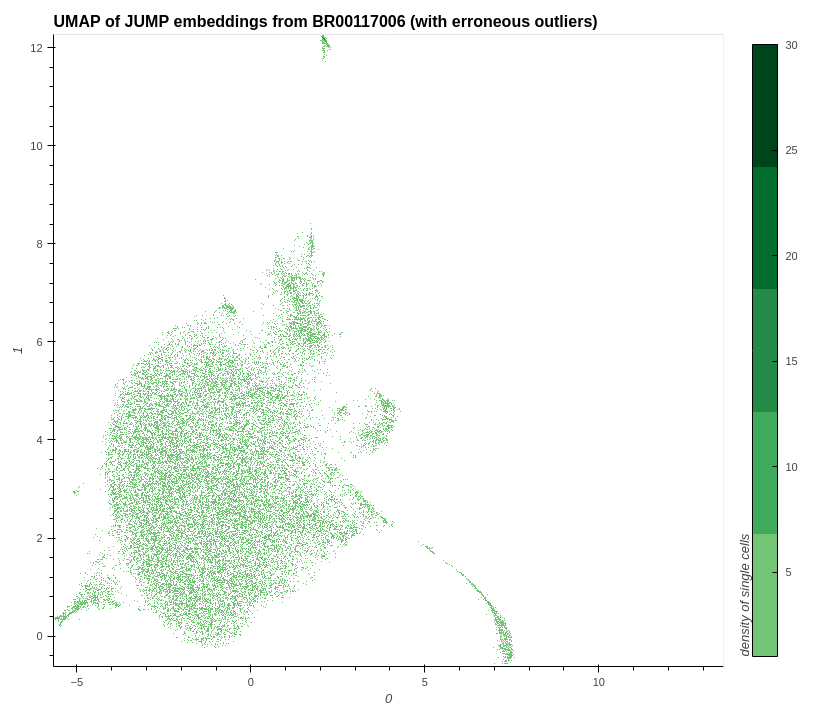

In [24]:
plot_hvplot_scatter(
    embeddings=embeddings_with_outliers,
    title=f"UMAP of JUMP embeddings from {example_plate} (with erroneous outliers)",
    filename=(
        image_with_all_outliers := f"./images/umap_with_all_outliers_{example_plate}.png"
    ),
    bgcolor="white",
    cmap=px.colors.sequential.Greens[4:],
    clabel="density of single cells",
)
# conserve filespace by displaying export instead of dynamic plot
Image(image_with_all_outliers)

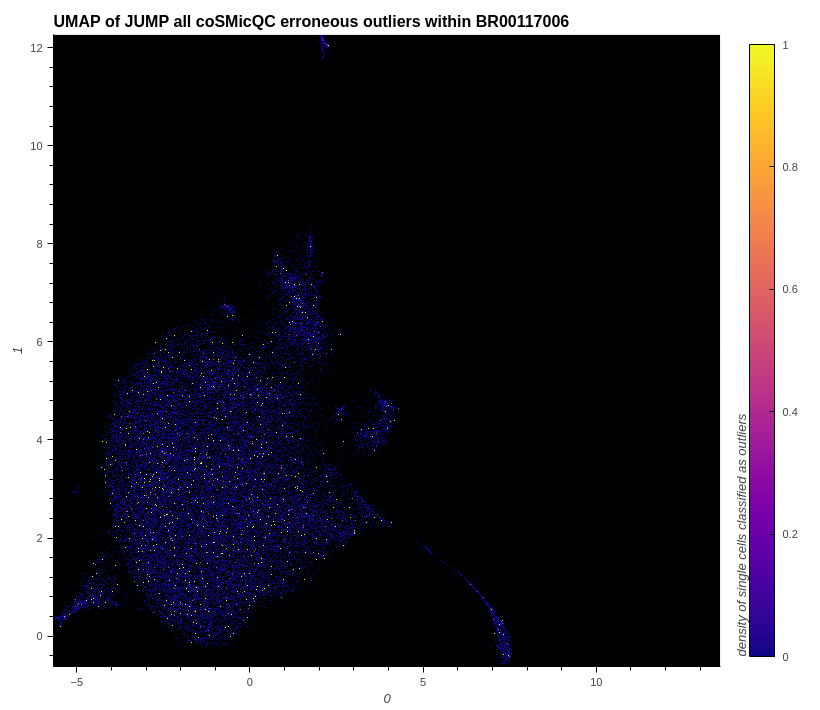

In [25]:
# show a UMAP for all outliers within the data
plot_hvplot_scatter(
    embeddings=embeddings_with_outliers,
    title=f"UMAP of JUMP all coSMicQC erroneous outliers within {example_plate}",
    filename=(
        image_with_outliers := f"./images/umap_erroneous_outliers_{example_plate}.png"
    ),
    color_dataframe=df_features_with_cqc_outlier_data,
    color_column="analysis.included_at_least_one_outlier",
    clabel="density of single cells classified as outliers",
)

# conserve filespace by displaying export instead of dynamic plot
Image(image_with_outliers)

In [26]:
# prepare data for normalization and feature selection
# by removing cosmicqc and analaysis focused columns.
df_for_normalize_and_feature_select_without_outliers = df_features_with_cqc_outlier_data[
    # seek values which are false (not considered an outlier)
    ~df_features_with_cqc_outlier_data["analysis.included_at_least_one_outlier"]
][
    # read feature names from cytotable output, which excludes
    # cosmicqc-added columns.
    parquet.read_schema(merged_single_cells).names
]
# show the modified column count
len(df_for_normalize_and_feature_select_without_outliers.columns)

df_for_normalize_and_feature_select_without_outliers

,Metadata_ImageNumber,Image_Metadata_AbsPositionZ,Image_Metadata_AbsTime,Image_Metadata_BinningX,Image_Metadata_BinningY,Image_Metadata_ChannelID,Image_Metadata_ChannelName,Image_Metadata_Col,Image_Metadata_ExposureTime,Image_Metadata_FieldID,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,1119,0.134580,2020-11-03 01:12:09.290,2,2,5,HOECHST 33342,5,0.01,3,...,188.136270,223.444366,196.348149,201.692217,193.447304,191.112130,194.338794,205.641407,190.236222,198.995454
1,1125,0.134575,2020-11-03 01:12:18.387,2,2,5,HOECHST 33342,5,0.01,9,...,307.138707,352.777180,280.160417,293.907281,270.642670,257.492850,268.785849,277.387503,266.571322,284.912086
2,1120,0.134577,2020-11-03 01:12:10.803,2,2,5,HOECHST 33342,5,0.01,4,...,67.572643,52.253854,67.198215,65.973554,67.099209,69.764729,67.149215,64.467176,64.352774,67.241595
3,1124,0.134577,2020-11-03 01:12:16.857,2,2,5,HOECHST 33342,5,0.01,8,...,182.255135,186.273646,171.056953,150.516700,147.429986,148.456139,170.693650,164.615620,157.828872,162.132785
4,1125,0.134575,2020-11-03 01:12:18.387,2,2,5,HOECHST 33342,5,0.01,9,...,39.577476,21.283610,35.897498,36.097097,36.175652,38.252400,37.732823,33.677740,38.388491,40.384347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39152,3174,0.134431,2020-11-03 01:55:02.947,2,2,5,HOECHST 33342,17,0.01,6,...,159.058337,115.258242,130.619023,115.966416,118.448773,124.769018,126.691320,127.193235,119.042217,117.850916
39153,3170,0.134427,2020-11-03 01:54:56.770,2,2,5,HOECHST 33342,17,0.01,2,...,62.764788,53.632386,57.504651,58.947419,57.765383,63.620112,59.975922,59.814131,58.788261,66.756129
39154,3172,0.134425,2020-11-03 01:54:59.857,2,2,5,HOECHST 33342,17,0.01,4,...,40.874660,44.177903,37.178607,38.004406,38.772636,38.694829,38.587792,38.778026,39.212222,40.056736
39155,3170,0.134427,2020-11-03 01:54:56.770,2,2,5,HOECHST 33342,17,0.01,2,...,164.419348,183.455783,166.211734,138.889418,133.995824,134.760379,165.046365,139.673023,135.101638,138.366898


In [27]:
print("Length of dataset with outliers: ", len(df_for_normalize_and_feature_select))
print(
    "Length of dataset without outliers: ",
    len(df_for_normalize_and_feature_select_without_outliers),
)

Length of dataset with outliers:  39157
Length of dataset without outliers:  37948


In [28]:
parquet_pycytominer_annotated_wo_outliers = (
    f"./{example_plate}_annotated_wo_outliers.parquet"
)

# check if we already have annotated data
if not pathlib.Path(parquet_pycytominer_annotated_wo_outliers).is_file():
    # annotate the data using pycytominer
    pycytominer.annotate(
        profiles=df_for_normalize_and_feature_select_without_outliers,
        # read the platemap directly from AWS S3 related location
        platemap=df_platemap_and_metadata,
        join_on=["Metadata_well_position", "Metadata_Well"],
        output_file=parquet_pycytominer_annotated_wo_outliers,
        output_type="parquet",
    )

In [29]:
parquet_pycytominer_normalized_wo_outliers = (
    f"./{example_plate}_normalized_wo_outliers.parquet"
)

# check if we already have normalized data
if not pathlib.Path(parquet_pycytominer_normalized_wo_outliers).is_file():
    # normalize the data using pcytominer
    df_pycytominer_normalized = pycytominer.normalize(
        profiles=parquet_pycytominer_annotated_wo_outliers,
        features="infer",
        image_features=False,
        meta_features="infer",
        method="standardize",
        samples="Metadata_control_type == 'negcon'",
        output_file=parquet_pycytominer_normalized_wo_outliers,
        output_type="parquet",
    )

In [30]:
parquet_pycytominer_feature_selected_wo_outliers = (
    f"./{example_plate}_feature_select_wo_outliers.parquet"
)

# check if we already have feature selected data
if not pathlib.Path(parquet_pycytominer_feature_selected_wo_outliers).is_file():
    # feature select normalized data using pycytominer
    df_pycytominer_feature_selected = pycytominer.feature_select(
        profiles=parquet_pycytominer_normalized_wo_outliers,
        operation=[
            "variance_threshold",
            "correlation_threshold",
            "blocklist",
            "drop_na_columns",
        ],
        na_cutoff=0,
        output_file=parquet_pycytominer_feature_selected_wo_outliers,
        output_type="parquet",
    )

In [31]:
# calculate UMAP embeddings from data without coSMicQC-detected outliers
embeddings_without_outliers = generate_umap_embeddings(
    df_input=pd.read_parquet(parquet_pycytominer_feature_selected_wo_outliers),
    cols_metadata_to_exclude=all_metadata_cols,
    random_state=0,
)
# show the shape and top values from the embeddings array
print(embeddings_without_outliers.shape)
embeddings_without_outliers[:3]

(37948, 2)


array([[-1.4753685,  2.328971 ],
       [-4.9449954, -3.5651774],
       [-0.7737871,  2.0379725]], dtype=float32)

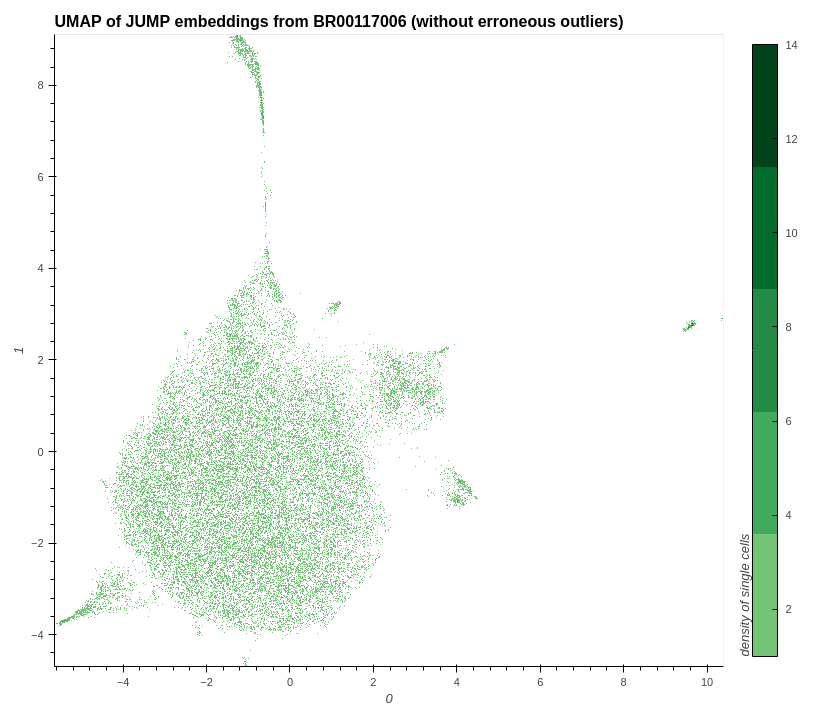

In [32]:
# plot UMAP for embeddings without outliers
plot_hvplot_scatter(
    embeddings=embeddings_without_outliers,
    title=f"UMAP of JUMP embeddings from {example_plate} (without erroneous outliers)",
    filename=(
        image_without_all_outliers := f"./images/umap_without_outliers_{example_plate}.png"
    ),
    bgcolor="white",
    cmap=px.colors.sequential.Greens[4:],
    clabel="density of single cells",
)
# conserve filespace by displaying export instead of dynamic plot
Image(image_without_all_outliers)

In [33]:
# compare the UMAP images with and without outliers side by side
HTML(
    f"""
    <div style="display: flex;">
      <img src="{image_with_all_outliers}" alt="UMAP which includes erroneous outliers" style="width: 50%;"/>
      <img src="{image_without_all_outliers}" alt="UMAP which includes no erroneous outliers" style="width: 50%;"/>
    </div>
    """
)

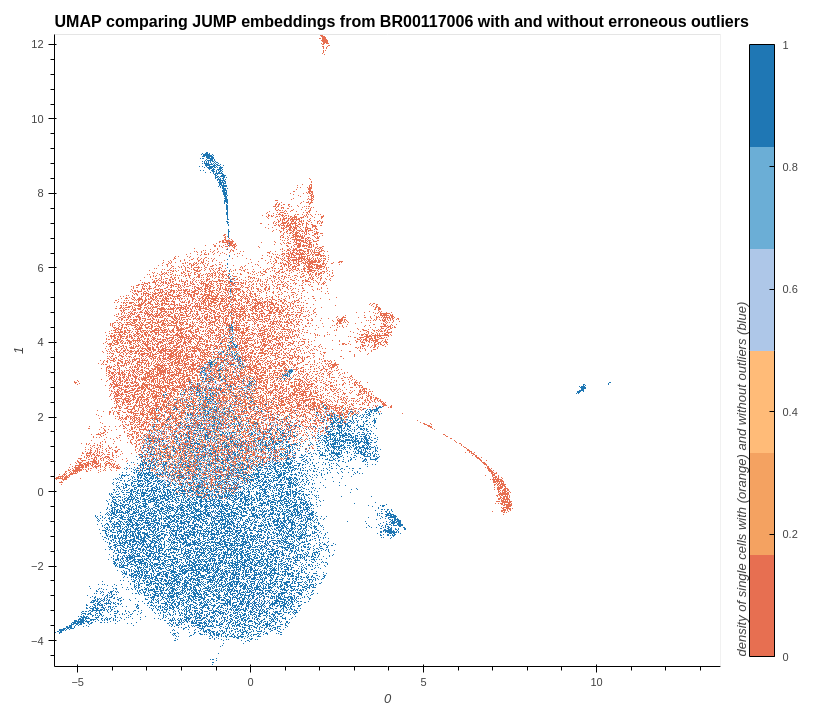

In [34]:
# concatenate embeddings together
combined_embeddings = np.vstack((embeddings_with_outliers, embeddings_without_outliers))

# Step 2: Create the labels array
combined_labels = np.concatenate(
    [np.zeros(len(embeddings_with_outliers)), np.ones(len(embeddings_without_outliers))]
)

# visualize UMAP embeddings both with and without outliers together for comparison
plot_hvplot_scatter(
    embeddings=combined_embeddings,
    title=f"UMAP comparing JUMP embeddings from {example_plate} with and without erroneous outliers",
    filename=(
        image_compare_umaps := f"./images/umap_comparison_with_and_without_erroneous_outliers_{example_plate}.png"
    ),
    color_dataframe=pd.DataFrame(
        combined_labels, columns=["combined_embedding_color_label"]
    ),
    color_column="combined_embedding_color_label",
    bgcolor="white",
    cmap=[
        "#e76f51",  # Darkest Orange
        "#f4a261",  # Darker Orange
        "#ffbb78",  # Light Orange
        "#aec7e8",  # Light Blue
        "#6baed6",  # Darker Blue
        "#1f77b4",  # Darkest Blue
    ],
    clabel="density of single cells with (orange) and without outliers (blue)",
)

# conserve filespace by displaying export instead of dynamic plot
Image(image_compare_umaps)